# Machine Learning with Spark on Google Cloud Dataproc

## Create a Dataproc cluster

In [ ]:
%%bash
# Clone the repository
git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp/
cd ~/data-science-on-gcp/06_dataproc

# Set the project and bucket variable
export PROJECT_ID=$(gcloud info --format='value(config.project)')
export BUCKET_NAME=$PROJECT_ID-dsongcp

# Create a Dataproc cluster
./create_cluster.sh $BUCKET_NAME us-central1

## Start pyspark session

In [1]:
# Set up google cloud storage bucket 
PROJECT=!gcloud config get-value project
PROJECT=PROJECT[0]
BUCKET = PROJECT + '-dsongcp'
import os
os.environ['BUCKET'] = PROJECT + '-dsongcp'

In [2]:
# Create a spark session
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/29 07:51:58 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/29 07:51:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/29 07:51:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/05/29 07:51:58 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Create a Spark Dataframe for training
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

## Read and clean up dataset

In [4]:
# Read the dataset
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [5]:
# Create a Spark SQL view
traindays.createOrReplaceTempView('traindays')

In [6]:
# Query the first few records from the training dataset view
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [7]:
# Use shard files, a representative subset of the full dataset
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)

In [8]:
# Read the data into SparkSQL
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

In [9]:
# Create a query that uses data only from days identified as part of the training dataset
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [10]:
# Inspect the data
print(traindata.head(2))

[Row(DEP_DELAY=-3.0, TAXI_OUT=14.0, ARR_DELAY=-16.0, DISTANCE='370.00'), Row(DEP_DELAY=24.0, TAXI_OUT=12.0, ARR_DELAY=12.0, DISTANCE='370.00')]


In [11]:
# Some analysis of the dataset
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46439|             46422|             46355|            46936|
|   mean| 8.561769202609876|15.427685149282668|3.2853413871211306|916.0707133117437|
| stddev|30.752752455053308| 8.427384168645757| 32.98848343691196|591.9164453757172|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [12]:
# Clean the dataset
# There are different count stats for all of the variables beause:
# - Flights are scheduled but never depart
# - Some depart but are cancelled before take off
# - Sone flights are diverted and therefore never arrive
# Remove NULLs in the delay variables (these correspond to canceled or diverted flights).
trainquery = """
SELECT
DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
t.is_train_day == 'True' AND
f.dep_delay IS NOT NULL AND 
f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [13]:
# Remove flights that have been cancelled or diverted
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == 'False' AND 
  f.DIVERTED == 'False'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



## Develop a logistic regression model

In [14]:
# Converts data into a training example, which contains a sample of the input features
# and the correct label for those inputs
# Label = arrival delay < 15 mins
# Inputs = departure delay, taxi out and flight distance
def to_example(fields):
    return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [15]:
# Map training example function to the training dataset
examples = traindata.rdd.map(to_example)

In [16]:
# Creates a logistic regression model based on training dataset
# <intercept=True> because the prediction of arrival delay is nonzero when 
# all of the inputs are zero 
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)

22/05/29 07:54:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/29 07:54:35 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [17]:
# The lrmodel object will have weights and an intercept
print(lrmodel.weights, lrmodel.intercept)

[-0.17926510230641074,-0.1353410840270897,0.00047781052266304745] 5.403405250989946


In [18]:
# Departure delay of 6 mins,
# Taxi-out time of 12 mins,
# Flight distance of 594 miles
# predicts the flight will be on time
print(lrmodel.predict([6.0,12.0,594.0]))

1


In [19]:
# Departure delay of 36 mins predicts the flight won't be on time
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [20]:
# Return the actual probability by clearing the threshold
lrmodel.clearThreshold()
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

0.9520080900763146
0.08390675828170738


In [21]:
# Set the threshold = 0.7 corresponds to requirement of cancelling meetings if 
# the probability of on time arrival falls below 70%
lrmodel.setThreshold(0.7) 
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

1
0


## Save and restore a model

In [22]:
# Make sure storage location is empty
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'
os.system('gsutil -m rm -r ' + MODEL_FILE)

CommandException: 1 files/objects could not be removed.


256

In [23]:
# Save the model
lrmodel.save(sc, MODEL_FILE)
print('{} saved'.format(MODEL_FILE))

gs://qwiklabs-gcp-04-4790a6e5810a-dsongcp/flights/sparkmloutput/model saved


In [24]:
# Destroy the model
lrmodel = 0
print(lrmodel)

0


In [25]:
# Retrieve the model from storage
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

## Predict with the logistic regression model

In [26]:
# Predicting the flight will probably arrive late,
# given 70% probability threshold
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [27]:
# Predicting the flight will probably arrive on time,
# given 70% probability threshold
print(lrmodel.predict([8.0,4.0,594.0]))

1


## Examine model behavior

In [28]:
# To make the model produce probabilities
# The probability of arriving late increases as the departure delay increases
lrmodel.clearThreshold()
print(lrmodel.predict([20, 10, 500]))

0.6689849289476673


Text(0, 0.5, 'probability of ontime arrival')

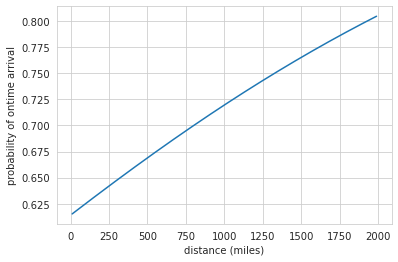

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

At a departure delay of 20 mins and a taxi-out time of 10 mins, the distance affects the probability that the flight is on time is relatively minor. The probability increases from about 0.63 to about 0.76 as the distance changes from very short hop to a cross-continent flight.

Text(0, 0.5, 'probability of ontime arrival')

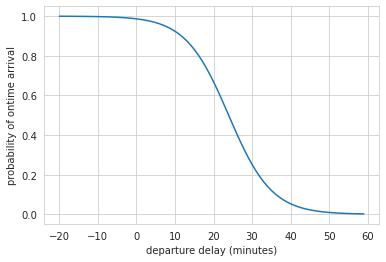

In [30]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

On the other hand, if hold the taxi-out time and distance constant, the dependence on departure delay is a more dramatic impact.

## Evaluate the model

In [31]:
# Need test data
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET)
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')
testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")

In [32]:
# Map the training example function to the test dataset
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [33]:
# Some analysis of the test dataset
testdata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             82184|             82184|             82184|            82184|
|   mean| 8.674377007690062|15.676676725396671|3.8409179402316753|838.9512557188747|
| stddev|38.764341740364586| 8.505730543334973| 41.25995960185183|600.3088554927516|
|    min|             -35.0|               1.0|             -70.0|          1005.00|
|    max|            1576.0|             154.0|            1557.0|           998.00|
+-------+------------------+------------------+------------------+-----------------+



In [37]:
# Define a function returns total cancel, total noncancel, correct cancel and 
# correct noncancel flight details
def eval(labelpred):
    ''' 
        data = (label, pred)
            data[0] = label
            data[1] = pred
    '''
    cancel = labelpred.filter(lambda data: data[1] < 0.7)
    nocancel = labelpred.filter(lambda data: data[1] >= 0.7)
    corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom}

In [38]:
# Evaluate the model by passing correct predicted label
# so it returns probabilities
lrmodel.clearThreshold() 
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print('All flights:')
print(eval(labelpred))

All flights:


{'total_cancel': 14689, 'correct_cancel': 0.8239498944788617, 'total_noncancel': 67495, 'correct_noncancel': 0.9556411586043411}


In [39]:
# Keep only those examples near the decision threshold > 65% & < 75%
print('Flights near decision threshold:')
labelpred = labelpred.filter(lambda data: data[1] > 0.65 and data[1] < 0.75)
print(eval(labelpred))

Flights near decision threshold:


{'total_cancel': 714, 'correct_cancel': 0.3711484593837535, 'total_noncancel': 850, 'correct_noncancel': 0.6788235294117647}
